In [1]:
%run uvms_dynamics.ipynb

jit after {'jit': True, 'jit_options': {'flags': '-Ofast'}, 'compiler': 'shell'}
number of joints = 4
floating_base found
floating_base found
floating_base found


In [2]:
# conditional function instances
# coupled forward dynamics of uvms
x_next_coupled, states, u, dt, q_min, q_max, manipulator_p, vehicle_p, base_T, states_checks, u_checks  = rig_dyn.forward_dynamics(gravity=9.81, 
                                                                                    floating_base_id=tau_F,
                                                                                    floating_base_bias_f=b_F , 
                                                                                    J_uv = J_uv, 
                                                                                    coupled=True)
x_next_coupled_eval = cs.Function('UVMSnext_coupled', [states, u, dt, manipulator_p, vehicle_p, base_T ,q_min, q_max], [x_next_coupled, u_checks])


# decoupled forward dynamics of uvms
x_next_decoupled, states, u, dt, q_min, q_max, manipulator_p, vehicle_p, base_T, states_checks, u_checks  = rig_dyn.forward_dynamics(gravity=9.81, 
                                                                                    floating_base_id=tau_F,
                                                                                    floating_base_bias_f=b_F , 
                                                                                    J_uv = J_uv, 
                                                                                    coupled=False)

x_next_decoupled_eval = cs.Function('UVMSnext_decoupled', [states, u, dt, manipulator_p, vehicle_p, base_T ,q_min, q_max], [x_next_decoupled, u_checks])



UVMSnext_use_coupled = cs.Function.if_else('UVMSnext_use_coupled', x_next_coupled_eval, x_next_decoupled_eval)

floating_base found
floating_base found
floating_base found
floating_base found
floating_base found
floating_base found


In [3]:
# # c , cpp or matlab code generation for forward dynamics
# UVMSnext_use_coupled.generate("x_next_eval.c")
# os.system(f"gcc -fPIC -shared x_next_eval.c -o libUVMS_xnext.so")

In [4]:
st_x0 = cs.vertcat(0,0,0, 0,0,0, 0.0, 3.4, 0.99245, 3.16073,   0, 0, 0, 0, 0, 0,  0.00751799, -0.0073626, 0.00281749, 0.0222385)
u0 = cs.vertcat(0.0, 0, 0, 0, 0, 0, 0.0, 1.0, 0.0, 0.0)

UVMSnext_use_coupled(True, st_x0, u0, alpha.delta_t, alpha.sim_p, blue.sim_p, alpha.base_T0, alpha.joint_min, alpha.joint_max)

(DM([-8.74517e-07, 7.05486e-07, 8.61766e-05, -1.23883e-05, 2.56848e-05, -3.20227e-05, 5.6418e-05, 3.39991, 0.992479, 3.16098, -2.30676e-05, 1.74815e-05, -0.00010673, -0.000301368, 0.00065418, -0.000767976, 9.72111e-06, -0.000135709, 2.13649e-05, 0.000271337]),
 DM([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

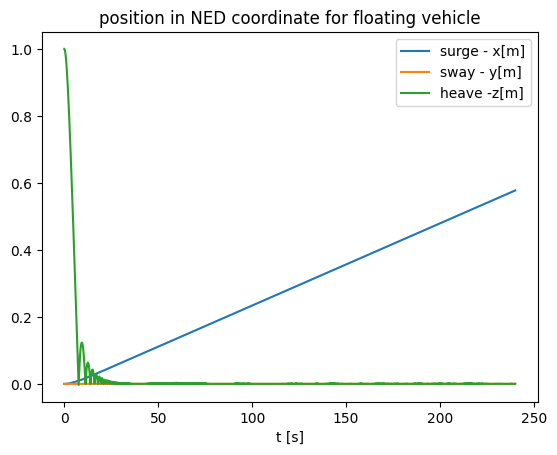

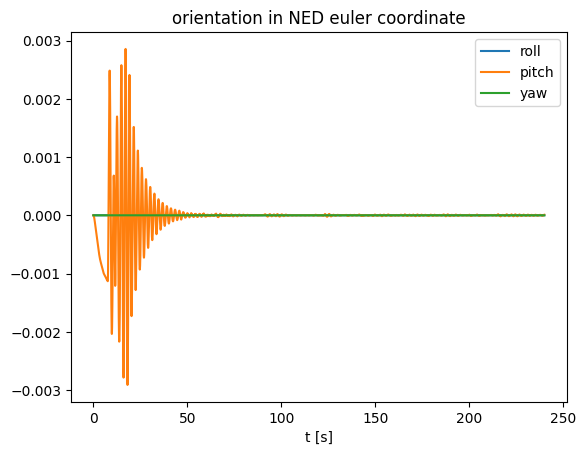

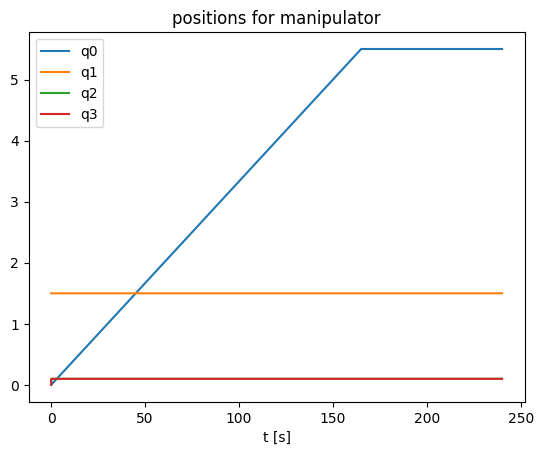

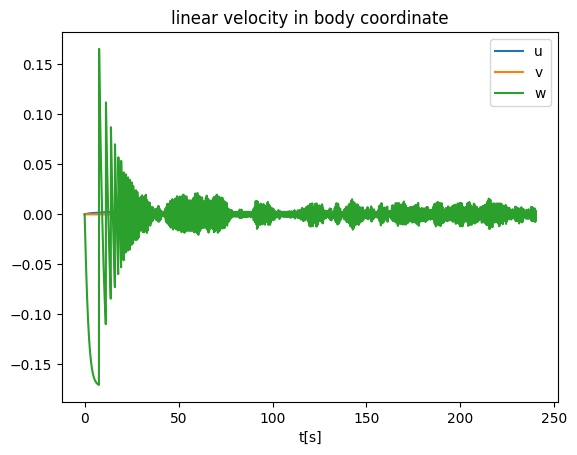

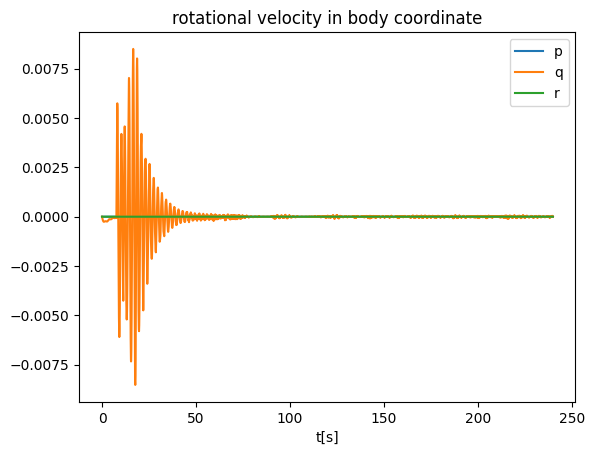

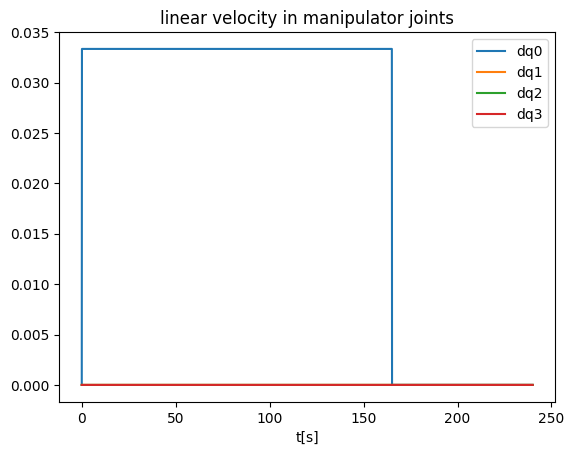

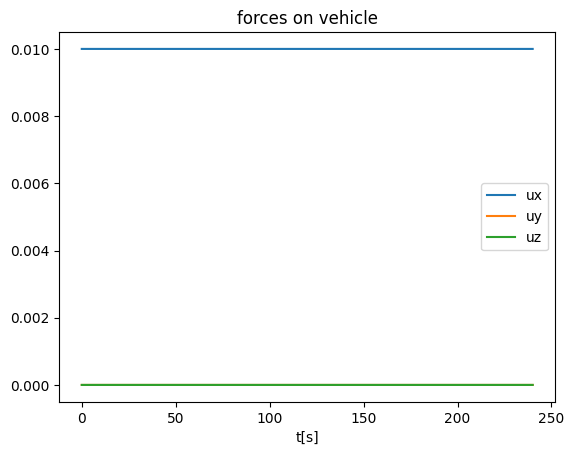

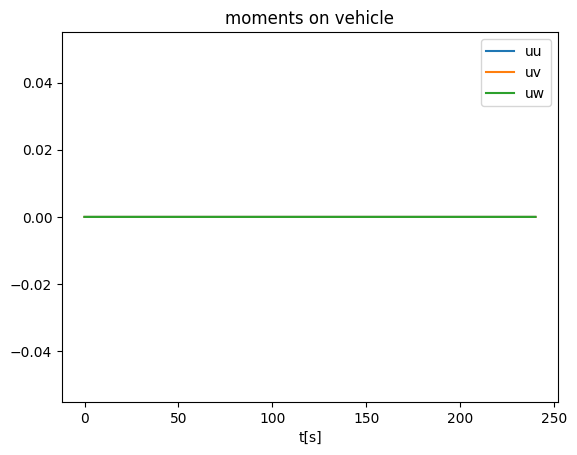

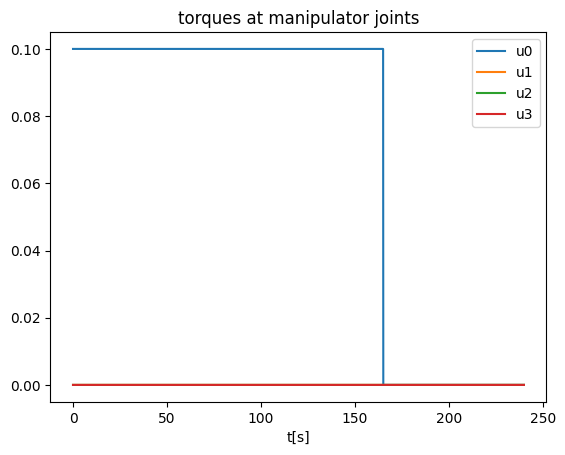

In [5]:
sim = x_next_decoupled_eval.mapaccum(alpha.N)
x0 = np.array([0, 0, 1, 0, 0, 0, 0.0, 1.5, 0.05, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #x y z r p y q0 q1 q2 q3 u v w p q r qd0 qd1 qd2 qd3 qd4
u0 = np.array([0.01, 0.0, 0, 0, 0, 0, 0.1, 0, 0, 0])
res = sim(x0, u0, alpha.delta_t, alpha.sim_p,  blue.sim_p,  alpha.base_T0, alpha.joint_min, alpha.joint_max)
t = np.linspace(0, alpha.sim_n, alpha.N+1)


# Create a figure and plot the data
plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((20,1)), res[0].toarray()), axis=1)[0:3,:].T)
plt.legend(['surge - x[m]', 'sway - y[m]', 'heave -z[m]'])
plt.title("position in NED coordinate for floating vehicle")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((20,1)), res[0].toarray()), axis=1)[3:6,:].T)
plt.legend(['roll', 'pitch', 'yaw'])
plt.title("orientation in NED euler coordinate")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((20,1)), res[0].toarray()), axis=1)[6:10,:].T)
plt.legend(['q0', 'q1', 'q2', 'q3'])
plt.title("positions for manipulator")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((20,1)), res[0].toarray()), axis=1)[10:13,:].T)
plt.legend(['u', 'v', 'w'])
plt.xlabel('t[s]')
plt.title("linear velocity in body coordinate")
plt.show()

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((20,1)), res[0].toarray()), axis=1)[13:16,:].T)
plt.legend(['p', 'q', 'r'])
plt.xlabel('t[s]')
plt.title("rotational velocity in body coordinate")
plt.show()

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((20,1)), res[0].toarray()), axis=1)[16:20,:].T)
plt.legend(['dq0', 'dq1', 'dq2', 'dq3'])
plt.xlabel('t[s]')
plt.title("linear velocity in manipulator joints")
plt.show()

plt.figure()
plt.plot(t, np.concatenate((np.array(u0).reshape((10,1)), res[1].toarray()), axis=1)[0:3,:].T)
plt.legend(['ux', 'uy', 'uz'])
plt.xlabel('t[s]')
plt.title("forces on vehicle")
plt.show()


plt.figure()
plt.plot(t, np.concatenate((np.array(u0).reshape((10,1)), res[1].toarray()), axis=1)[3:6,:].T)
plt.legend(['uu', 'uv', 'uw'])
plt.xlabel('t[s]')
plt.title("moments on vehicle")
plt.show()

plt.figure()
plt.plot(t, np.concatenate((np.array(u0).reshape((10,1)), res[1].toarray()), axis=1)[6:10,:].T)
plt.legend(['u0', 'u1', 'u2', 'u3'])
plt.xlabel('t[s]')
plt.title("torques at manipulator joints")
plt.show()